In [5]:
import json
import numpy as np
import pandas as pd
import random
import requests
import os
import copy
import csv
import statistics

from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from scipy.stats import scoreatpercentile
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import weightedtau
from sklearn.cluster import KMeans

from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from string import ascii_letters
from tqdm.notebook import tqdm, trange


In [6]:
with open("heatmap_raw_data.json","r",encoding="utf-8") as f:
    raw_data = json.load(f)
    
output_collection = raw_data["output_collection"]
majority_collection = raw_data["majority_collection"]
testsize_collection = raw_data["testsize_collection"]
all_dist_collections = raw_data["all_dist_collections"]
output_collection_electra = raw_data["output_collection_electra"]

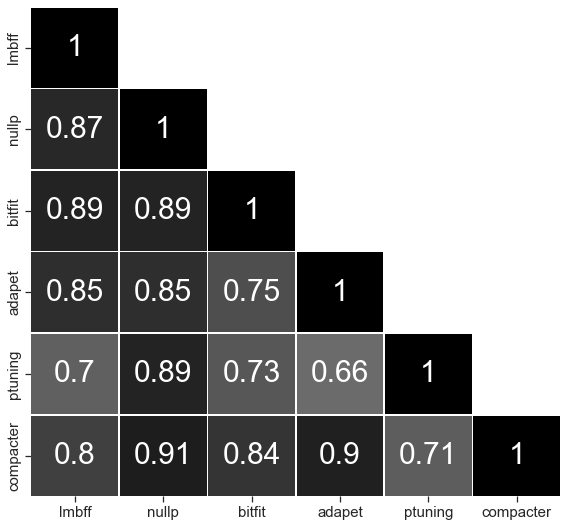

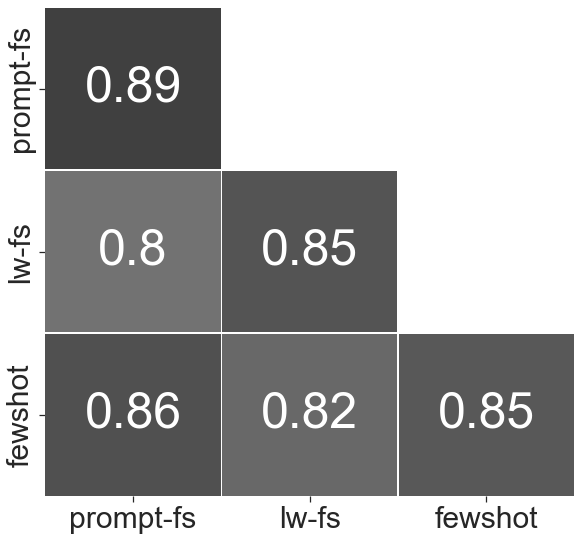

In [68]:
def heatmap_generation(aspects=["cola","sst2","mrpc","qqp","mnli","qnli","rte","boolq","cb","copa","wic"] \
                       , scope="clusters", mode = "corr"):

    method_cluster = {}
    method_cluster["prompt-fs"] = ["lmbff","nullp","bitfit","adapet"]
    method_cluster["lw-fs"] = ["ptuning","compacter"]
    method_cluster["fewshot"] = ["lmbff","nullp","bitfit","adapet","ptuning","compacter"]
    # method_cluster["fewshot-avg"] = ["few-avg"] 
#     method_cluster["lw-ft"] = ["p-tuning(f)","adapter(f)"]
#     method_cluster["lm-ft"] = ["roberta-b(f)","roberta-l(f)","bert-b(f)","bert-l(f)","t5-b(f)","t5-l(f)","t5-11b(f)"]
#     method_cluster["human"] = ["human"]



    included_tasks = ["cola","sst2","mrpc","qqp","mnli","qnli","rte","boolq","cb","copa","wic"]


    included_methods = []
    for k,v in method_cluster.items():
        for item in list(v):
            if item not in included_methods:      
                included_methods += [item]
    
    # included_tasks = aspects
    
    head = ["methods"]
    
    def generate_score(mode,lst1,lst2):
        if mode == "corr":
            return spearmanr(lst1, lst2)[0]
            # return pearsonr(lst1, lst2)[0]
        elif mode == "kendall_tau":
            return kendalltau(np.argsort(lst1), np.argsort(lst2))[0]
        elif mode == "weighted_tau":
            return weightedtau(np.argsort(lst1), np.argsort(lst2))[0]
        
    def cluster_score_avg(cluster1, cluster2, task_collector):
        all_score = 0
        for v1 in cluster1:
            for v2 in cluster2:
                all_score += task_collector[v1][v2]
                
        return all_score/(len(cluster1)*len(cluster2))
    
    def extract_score(method,task):
        temp_score = 0
        temp_collection = {}
        if method in output_collection.keys():
            temp_collection = output_collection
        else:
            temp_collection = output_dic
            
        if method in ["sensitivity","diversity"]:
            temp_score -= temp_collection[method][task]*100
        elif method in ["rda","coverage"]:
            # rda is computed as a sum over the examples
            temp_score -= temp_collection[method][task]
        else:
            temp_score += temp_collection[method][task]-majority_collection[task]
                    
        return temp_score

    # capture the correlation for each two tasks 
    df = pd.DataFrame()
    task_collector = {}
    
    if scope == "methods":
        for i,method in enumerate(included_methods):
            head.append(method)    
        df["methods"] = included_methods
    
    for method1 in included_methods:
        temp = []
        task_collector[method1] = {}
        
        for method2 in included_methods:
            lst1 = []
            lst2 = []

            for task in included_tasks:
                lst1.append(extract_score(method1,task))
                lst2.append(extract_score(method2,task))

            temp_score = generate_score(mode,lst1,lst2)
            temp.append(round(temp_score,4))
            task_collector[method1][method2] = temp_score 
            
        if scope == "methods":
            df[method1] = temp
            
            
    if scope == "methods":
        df.set_index('methods', drop=True, inplace=True)
    
        
    if scope == "clusters":
            for key in list(method_cluster.keys()):
                head.append(key)
                
            df["clusters"] = list(method_cluster.keys())
            
            for cluster1 in df["clusters"]:
                temp = []
                for cluster2 in df["clusters"]:
                    temp_score = cluster_score_avg(method_cluster[cluster1], method_cluster[cluster2], task_collector)
                    temp.append(round(temp_score,4))
            
                df[cluster1] = temp

            df.set_index('clusters', drop=True, inplace=True)
        
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(figsize=(9.5, 9))

    mask[0][0] = False
    mask[1][1] = False
    mask[2][2] = False
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    if scope == "clusters":
        sns.heatmap(df,annot=True,mask=mask, cmap='gist_gray_r', vmax=1, center=0.78,cbar=False,
                    square=False, linewidths=.6, cbar_kws={"shrink": .5}, annot_kws={"fontsize":50})
        
        ax.set(ylabel=None)
        ax.tick_params(axis='x', labelsize= 30)
        ax.tick_params(axis='y', labelsize= 30)
    
    
    if scope == "methods":
        
        mask[3][3] = False
        mask[4][4] = False
        mask[5][5] = False
        sns.heatmap(df,annot=True,mask=mask, cmap='gist_gray_r', vmax=1, center=0.6,cbar=False,
            square=False, linewidths=.6, cbar_kws={"shrink": .5}, annot_kws={"fontsize":30})
        
        ax.set(ylabel=None)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)

    
    # image_format = 'svg' # e.g .png, .svg, etc.
    # image_name = 'glue_intrinsic_'+scope[:-1]+'.svg'
    # f.savefig(image_name, format=image_format, dpi=1200)
    
    image_name = 'glue_intrinsic_'+scope[:-1]+'.pdf'
    f.savefig(image_name, format="pdf", bbox_inches="tight", dpi=1200)

    plt.show()
    
heatmap_generation(scope="methods")
heatmap_generation(scope="clusters")

In [71]:
def percentile_filter(dists, percentile):
    threshold = np.percentile(dists, percentile)
    new_dists = []

    for dist in dists:
        if dist >= threshold:
            new_dists.append(10**dist)
            
    # print(threshold)
    return(sum(new_dists)/len(new_dists))


def heatmap_generation(aspects, scope="clusters", mode = "corr"):
    # scope: methods,clusters
    method_cluster = {}
    method_cluster["prompt-fs"] = ["lmbff","nullp","bitfit","adapet"] # "manual",
    method_cluster["lw-fs"] = ["ptuning","compacter"] #,"compacter""adapter"
#     method_cluster["fewshot-avg"] = ["few-avg"] 
    method_cluster["fewshot"] = ["lmbff","nullp","bitfit","adapet","ptuning","compacter"] #"manual",,"few-avg"

    method_cluster["Spread"] = ["Spread"]
    method_cluster["sensitivity"] = ["sensitivity"]
    method_cluster["rda"] = ["rda"]
#     method_cluster["hardness-avg"] = ["sensitivity","rda"]
    

    included_methods = []
    for k,v in method_cluster.items():
        for item in list(v):
            if item not in included_methods:      
                included_methods += [item]
    
    included_tasks = aspects
    
    head = ["methods"]
    
    def generate_score(mode,lst1,lst2):
        if mode == "corr":
            return spearmanr(lst1, lst2)[0]
            # return pearsonr(lst1, lst2)[0]
        elif mode == "kendall_tau":
            return kendalltau(np.argsort(lst1), np.argsort(lst2))[0]
        elif mode == "weighted_tau":
            return weightedtau(np.argsort(lst1), np.argsort(lst2))[0]
        
    def cluster_score_avg(cluster1, cluster2, task_collector):
        all_score = 0
        for v1 in cluster1:
            for v2 in cluster2:
                all_score += task_collector[v1][v2]
                
        return all_score/(len(cluster1)*len(cluster2))
    
    def extract_score(method,task):
        temp_score = 0
        
        if method in ["sensitivity","diversity"]:
            temp_score -= output_collection[method][task]*100
        elif method in ["rda","coverage"]:
            # rda is computed as a sum over the examples
            temp_score -= output_collection[method][task]# /(testsize_collection[task]/100) # 0
        elif method == "Spread":
            temp_score = -1*percentile_filter(all_dist_collections[task], 99.9)
        else:
            temp_score += output_collection[method][task]-majority_collection[task]*100
        
        return temp_score

    # capture the correlation for each two tasks 
    df = pd.DataFrame()
    task_collector = {}
    
    if scope == "methods":
        for i,method in enumerate(included_methods):
            head.append(method)    
        df["methods"] = included_methods
    
    for method1 in included_methods:
        temp = []
        task_collector[method1] = {}
        
        for method2 in included_methods:
            lst1 = []
            lst2 = []

            for task in included_tasks:
                lst1.append(extract_score(method1,task))
                lst2.append(extract_score(method2,task))

            temp_score = generate_score(mode,lst1,lst2)
            temp.append(round(temp_score,2))
            task_collector[method1][method2] = temp_score 
            
        if scope == "methods":
            df[method1] = temp
            
            
    if scope == "methods":
        df.set_index('methods', drop=True, inplace=True)
    
        
    if scope == "clusters":
            for key in list(method_cluster.keys()):
                head.append(key)
                
            df["clusters"] = list(method_cluster.keys())
            
            for cluster1 in df["clusters"]:
                temp = []
                for cluster2 in df["clusters"]:
                    temp_score = cluster_score_avg(method_cluster[cluster1], method_cluster[cluster2], task_collector)
                    temp.append(round(temp_score,2))
            
                df[cluster1] = temp

            df.set_index('clusters', drop=True, inplace=True)
    
    # print the averaged fewshot correlation
    if scope == "methods":
        for col in df:
            temp = 0
            dup = 0
            for method in method_cluster["fewshot"]:
                if method != col:
                    temp += df[col][method]
                else:
                    dup = 1
            print(col,":", round(temp/(len(method_cluster["fewshot"])-dup),2))
        
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(figsize=(9, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    for i in range(len(mask)):
        mask[i][i] = False
    
    if scope == "methods":
        sns.heatmap(df,annot=True,mask=mask, cmap='gist_gray_r', vmax=1, center=0.3,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":20})
        ax.tick_params(axis='x', labelsize= 10)
        ax.tick_params(axis='y', labelsize= 10)
    else:
        sns.heatmap(df,annot=True,mask=mask, cmap='gist_gray_r', vmax=1, center=0.6,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":50})
        ax.tick_params(axis='x', labelsize= 30)
        ax.tick_params(axis='y', labelsize= 30)
        
    ax.set(ylabel=None)

#     image_format = 'svg' # e.g .png, .svg, etc.
#     image_name = 'nli_intrinsic_'+scope[:-1]+'.svg'
#     f.savefig(image_name, format=image_format, dpi=1200)
    
    image_name = 'nli_intrinsic_'+scope[:-1]+'.pdf'
    f.savefig(image_name, format="pdf", bbox_inches="tight", dpi=1200)


lmbff : 0.72
nullp : 0.78
bitfit : 0.8
adapet : 0.63
ptuning : 0.72
compacter : 0.71
Spread : 0.52
sensitivity : 0.02
rda : 0.41


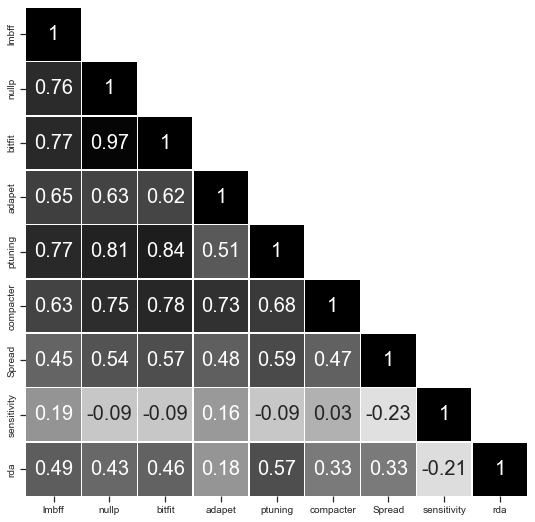

In [72]:
temp_aspects = ['anaphora', 'boolean', 'comparative', 'conditional', 'counting', \
                'event', 'gender', 'lexico_syntactic', 'mnli', 'monotonicity', \
                'monotonicity_hard', 'monotonicity_simple', 'negation', 'ner','ner_merged', \
                'ner_entity', 'ner_event', 'ner_location', \
                'ner_organization', 'ner_person', 'ner_time',  \
                'paraphrase', 'puns','quantifier', 'relation_extraction', 'rte', 'semantic_role', 'sentiment']

heatmap_generation(temp_aspects, scope="methods", mode = "corr")
# heatmap_generation(temp_aspects, scope="clusters", mode = "corr")

In [13]:
def electra_heatmap_generation(aspects, scope="clusters", mode = "corr"):
    # scope: methods,clusters
    method_cluster = {}
    method_cluster["roberta_fs"]=["lmbff","nullp","bitfit","adapet"]
    
    method_cluster["lmbff"] = ["el_lmbff"]
    method_cluster["nullp"] = ["el_nullp"]
    method_cluster["bitfit"] = ["el_bitfit"]
    method_cluster["adapet"] = ["el_adapet"]
    
    # method_cluster["electra_fs"] = ["el_lmbff","el_nullp","el_bitfit","el_adapet"]
    # method_cluster["hardness-avg"] = ["sensitivity","rda"]
    # method_cluster["ours"] = ["diversity","coverage"] #,"mixed"

    included_methods = []
    for k,v in method_cluster.items():
        for item in list(v):
            if item not in included_methods:      
                included_methods += [item]
    
    included_tasks = aspects
    
    head = ["methods"]
    
    def generate_score(mode,lst1,lst2):
        if mode == "corr":
            return spearmanr(lst1, lst2)[0]
            # return pearsonr(lst1, lst2)[0]
        elif mode == "kendall_tau":
            return kendalltau(np.argsort(lst1), np.argsort(lst2))[0]
        elif mode == "weighted_tau":
            return weightedtau(np.argsort(lst1), np.argsort(lst2))[0]
        
    def cluster_score_avg(cluster1, cluster2, task_collector):
        all_score = 0
        for v1 in cluster1:
            for v2 in cluster2:
                all_score += task_collector[v1][v2]
                
        return all_score/(len(cluster1)*len(cluster2))
    
    def extract_score(method,task):
        temp_score = 0
        
        if method in ["sensitivity","diversity"]:
            temp_score -= output_collection[method][task]*100
        elif method in ["rda","coverage"]:
            # rda is computed as a sum over the examples
            temp_score -= output_collection[method][task]# /(testsize_collection[task]/100) # 0
        elif "el_" in method:
            temp_score += output_collection_electra[method.replace("el_","")][task]-majority_collection[task]*100
        else:
            temp_score += output_collection[method][task]-majority_collection[task]*100
        
        return temp_score

    # capture the correlation for each two tasks 
    df = pd.DataFrame()
    task_collector = {}
    
    if scope == "methods":
        for i,method in enumerate(included_methods):
            head.append(method)    
        df["methods"] = included_methods
    
    for method1 in included_methods:
        temp = []
        task_collector[method1] = {}
        
        for method2 in included_methods:
            lst1 = []
            lst2 = []

            for task in included_tasks:
                lst1.append(extract_score(method1,task))
                lst2.append(extract_score(method2,task))

            temp_score = generate_score(mode,lst1,lst2)
            temp.append(round(temp_score,2))
            task_collector[method1][method2] = temp_score 
            
        if scope == "methods":
            df[method1] = temp
            
            
    if scope == "methods":
        df.set_index('methods', drop=True, inplace=True)
    
        
    if scope == "clusters":
            for key in list(method_cluster.keys()):
                head.append(key)
                
            df["clusters"] = list(method_cluster.keys())
            
            for cluster1 in df["clusters"]:
                temp = []
                for cluster2 in df["clusters"]:
                    temp_score = cluster_score_avg(method_cluster[cluster1], method_cluster[cluster2], task_collector)
                    temp.append(round(temp_score,2))
            
                df[cluster1] = temp

            df.set_index('clusters', drop=True, inplace=True)
            
    if scope == "methods":
        for col in df:
            temp = 0
            dup = 0
            for method in method_cluster["roberta_fewshot"]:
                if method != col:
                    temp += df[col][method]
                else:
                    dup = 1
            print(col,":", round(temp/(len(method_cluster["roberta_fewshot"])-dup),2))
            
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(figsize=(9, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    for i in range(len(mask)):
        mask[i][i] = False
    
    if scope == "methods":
        sns.heatmap(df,annot=True,mask=mask, cmap='RdYlGn', vmax=1, center=0.6,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":30})
    else:
        sns.heatmap(df,annot=True,mask=mask, cmap='RdYlGn', vmax=1, center=0.4,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":30})
        
    ax.set(ylabel=None)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'heatmap3.svg'

    f.savefig(image_name, format=image_format, dpi=1200)

In [16]:
# electra_heatmap_generation(temp_aspects, scope="clusters", mode = "corr")

In [73]:
def electra_heatmap_generation_v2(aspects, scope="clusters", mode = "corr"):
    # scope: methods,clusters
    method_cluster = {}
    method_cluster["roberta_fs"]=["rb_lmbff","rb_nullp","rb_bitfit","rb_adapet"]#"manual",,"few-avg"
    el_methods = ["el_lmbff","el_nullp","el_bitfit","el_adapet"]
    # method_cluster["hardness-avg"] = ["sensitivity","rda"]
    # method_cluster["ours"] = ["diversity","coverage"] #,"mixed"

    included_methods = []
    for k,v in method_cluster.items():
        for item in list(v):
            if item not in included_methods:      
                included_methods += [item]
    
    included_tasks = aspects
    
    head = ["methods"]
    
    def generate_score(mode,lst1,lst2):
        if mode == "corr":
            return spearmanr(lst1, lst2)[0]
            # return pearsonr(lst1, lst2)[0]
        elif mode == "kendall_tau":
            return kendalltau(np.argsort(lst1), np.argsort(lst2))[0]
        elif mode == "weighted_tau":
            return weightedtau(np.argsort(lst1), np.argsort(lst2))[0]
        
    def cluster_score_avg(cluster1, cluster2, task_collector):
        all_score = 0
        for v1 in cluster1:
            for v2 in cluster2:
                all_score += task_collector[v1][v2]
                
        return all_score/(len(cluster1)*len(cluster2))
    
    def extract_score(method,task):
        temp_score = 0
        
        if method in ["sensitivity","diversity"]:
            temp_score -= output_collection[method][task]*100
        elif method in ["rda","coverage"]:
            # rda is computed as a sum over the examples
            temp_score -= output_collection[method][task]# /(testsize_collection[task]/100) # 0
        elif "el_" in method:
            temp_score += output_collection_electra[method.replace("el_","")][task]-majority_collection[task]*100
        elif "rb_" in method:
            temp_score += output_collection[method.replace("rb_","")][task]-majority_collection[task]*100
        else:
            temp_score += output_collection[method][task]-majority_collection[task]*100
        
        return temp_score

    # capture the correlation for each two tasks 
    df = pd.DataFrame()
    task_collector = {}
    
    if scope == "methods":
        for i,method in enumerate(included_methods):
            head.append(method)    
        df["methods"] = included_methods
    
    for method1 in el_methods: #included_methods:
        temp = []
        task_collector[method1] = {}
        
        for method2 in included_methods: # el_methods:
            lst1 = []
            lst2 = []

            for task in included_tasks:
                lst1.append(extract_score(method1,task))
                lst2.append(extract_score(method2,task))

            temp_score = generate_score(mode,lst1,lst2)
            temp.append(round(temp_score,2))
            task_collector[method1][method2] = temp_score 
            
        if scope == "methods":
            df[method1] = temp
            
            
    if scope == "methods":
        df.set_index('methods', drop=True, inplace=True)
    
        
    if scope == "clusters":
            for key in list(method_cluster.keys()):
                head.append(key)
                
            df["clusters"] = list(method_cluster.keys())
            
            for cluster1 in df["clusters"]:
                temp = []
                for cluster2 in df["clusters"]:
                    temp_score = cluster_score_avg(method_cluster[cluster1], method_cluster[cluster2], task_collector)
                    temp.append(round(temp_score,2))
            
                df[cluster1] = temp

            df.set_index('clusters', drop=True, inplace=True)

            
    mask = np.triu(np.ones_like(df, dtype=bool))
    f, ax = plt.subplots(figsize=(9, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    for i in range(len(mask)):
        mask[i][i] = False
        
    sns.set_theme(style="ticks")
    if scope == "methods":
        # cmap='RdYlGn'
        sns.heatmap(df,annot=True,mask=mask, cmap='gist_gray_r', vmax=1, center=0.3,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":30})
    else:
        sns.heatmap(df,annot=True,mask=mask, cmap='BuGn', vmax=1, center=0.3,cbar=False,
                square=False, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":30})
        
    ax.set(ylabel=None)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    
    image_format = 'pdf' # e.g .png, .svg, etc.
    image_name = 'backbone_ablation.pdf'

    f.savefig(image_name, format="pdf", bbox_inches="tight", dpi=1200)

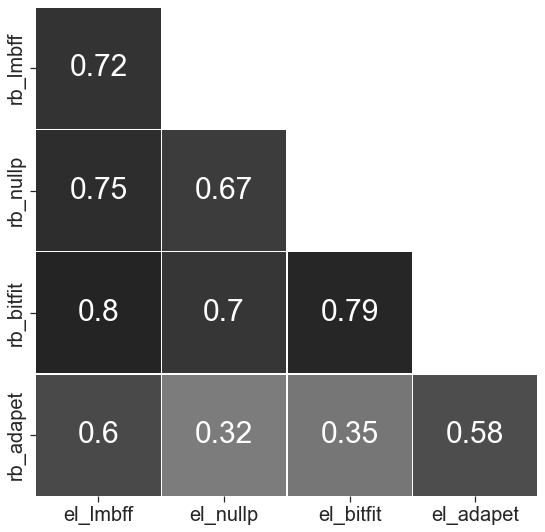

In [74]:
electra_heatmap_generation_v2(temp_aspects, scope="methods", mode = "corr")